In [1]:
import os
from math import ceil
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
ROOT = "Oral Cancer Prediction"
DATA_PATH = os.path.join(ROOT, "assets", "dataset")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [ ]:
ds = image_dataset_from_directory(
    DATA_PATH, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True, seed=123
)

Found 730 files belonging to 2 classes.


In [ ]:
CLASS_NAMES = ds.class_names
print(CLASS_NAMES)

class_counts = {
    0: os.listdir(os.path.join(DATA_PATH, CLASS_NAMES[0])).__len__(),
    1: os.listdir(os.path.join(DATA_PATH, CLASS_NAMES[1])).__len__(),
}
print(class_counts)

['cancer', 'normal']
{0: 199, 1: 531}


# Bulding the model


In [ ]:
def report(model_name, report_on="val"):
    ds_map = {"train": train_ds, "val": val_ds, "test": test_ds}
    selected_ds = ds_map[report_on]

    # Evaluate model on training, validation, and testing datasets
    train_eval = model_name.evaluate(train_ds)
    val_eval = model_name.evaluate(val_ds)
    test_eval = model_name.evaluate(test_ds)

    print(
        f"[train] acc: {train_eval[1]:.4f} - auc: {train_eval[2]:.4f} - loss: {train_eval[0]:.4f}"
    )
    print(
        f"[val]   acc: {val_eval[1]:.4f} - auc: {val_eval[2]:.4f} - loss: {val_eval[0]:.4f}"
    )
    print(
        f"[test]  acc: {test_eval[1]:.4f} - auc: {test_eval[2]:.4f} - loss: {test_eval[0]:.4f}\n"
    )

    # Get True and Predicted results
    y_true = np.concatenate([y.numpy() for x, y in selected_ds], axis=0)
    y_pred_probs = model_name.predict(selected_ds)
    y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

    print("cancer: 0, normal: 1")
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    name_map = {"train": "Training", "val": "Validation", "test": "Testing"}
    plt.title(f"Confusion Matrix on {name_map[report_on]} dataset")
    plt.show()

    # Generate Classification report
    print(f"Classifiation Report on {name_map[report_on]} dataset")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

In [ ]:
def train(
    model,
    train_ds,
    val_ds,
    opti="adam",
    log_monitor="val_auc",
    md="max",
    patience=5,
    batch_size=BATCH_SIZE,
    epochs=100,
):
    tf.keras.backend.clear_session()
    # Compile
    model.compile(
        optimizer=opti,
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC()],
    )

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor=log_monitor, patience=patience, mode=md, restore_best_weights=True
    )

    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stop],
    )

## Spliting dataset


In [ ]:
def dataset_partitions(
    ds, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size=1000
):
    if shuffle:
        ds.shuffle(shuffle_size)

    ds_size = len(ds)
    train_size = int(ds_size * train_split)
    val_size = ceil(ds_size * val_split)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    print(f"Number of batches  : {ds_size}")
    print(f"Training batches   : {train_size}")
    print(f"Validating batches : {val_size}")
    print(f"Testing batches    : {ds_size - train_size - val_size}")

    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = dataset_partitions(ds)

Number of batches  : 23
Training batches   : 18
Validating batches : 3
Testing batches    : 2


In [9]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Model design


In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),
    ]
)

In [ ]:
effnetB0_base_model = EfficientNetB0(weights="imagenet", include_top=False)
effnetB0_base_model.trainable = False

inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1.0 / 255)(x)
x = effnetB0_base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_effnetB0 = tf.keras.Model(inputs, outputs)

model_effnetB0.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
train(model_effnetB0, train_ds, val_ds, patience=10)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 491ms/step - accuracy: 0.9452 - auc: 0.9833 - loss: 0.1797 - val_accuracy: 0.9479 - val_auc: 0.9666 - val_loss: 0.1920
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9537 - auc: 0.9913 - loss: 0.1593 - val_accuracy: 0.9479 - val_auc: 0.9658 - val_loss: 0.1905
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9392 - auc: 0.9840 - loss: 0.1793 - val_accuracy: 0.9375 - val_auc: 0.9678 - val_loss: 0.1881
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9426 - auc: 0.9847 - loss: 0.1771 - val_accuracy: 0.9375 - val_auc: 0.9687 - val_loss: 0.1854
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9538 - auc: 0.9885 - loss: 0.1659 - val_accuracy: 0.9479 - val_auc: 0.9690 - val_loss: 0.1839
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9501 - auc: 0.9871 - loss: 0.1657 - val_accuracy: 0.9375 - val_auc: 0.9699 - val_loss: 0.1815
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Evaluate model on training, validation, and testing datasets
train_eval = model_name.evaluate(train_ds)
val_eval = model_name.evaluate(val_ds)
test_eval = model_name.evaluate(test_ds)

print(
    f"[train] acc: {train_eval[1]:.4f} - auc: {train_eval[2]:.4f} - loss: {train_eval[0]:.4f}"
)
print(
    f"[val]   acc: {val_eval[1]:.4f} - auc: {val_eval[2]:.4f} - loss: {val_eval[0]:.4f}"
)
print(
    f"[test]  acc: {test_eval[1]:.4f} - auc: {test_eval[2]:.4f} - loss: {test_eval[0]:.4f}\n"
)

# Get True and Predicted results
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)
y_pred_probs = model_name.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate Classification report
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9903 - auc: 0.9997 - loss: 0.0640
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9674 - auc: 0.9910 - loss: 0.1239
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.9666 - auc: 0.9801 - loss: 0.1383
[train] acc: 0.9861 - auc: 0.9994 - loss: 0.0650
[val]   acc: 0.9583 - auc: 0.9857 - loss: 0.1366
[test]  acc: 0.9655 - auc: 0.9886 - loss: 0.1282

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step
              precision    recall  f1-score   support

      cancer     0.2396    1.0000    0.3866        23
      normal     0.0000    0.0000    0.0000        73

    accuracy                         0.2396        96
   macro avg     0.1198    0.5000    0.1933        96
weighted avg     0.0574    0.2396    0.0926        96



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
train(model_effnetB0, train_ds, val_ds, patience=10)

# Evaluate model on training, validation, and testing datasets
train_eval = model_name.evaluate(train_ds)
val_eval = model_name.evaluate(val_ds)
test_eval = model_name.evaluate(test_ds)

print(
    f"[train] acc: {train_eval[1]:.4f} - auc: {train_eval[2]:.4f} - loss: {train_eval[0]:.4f}"
)
print(
    f"[val]   acc: {val_eval[1]:.4f} - auc: {val_eval[2]:.4f} - loss: {val_eval[0]:.4f}"
)
print(
    f"[test]  acc: {test_eval[1]:.4f} - auc: {test_eval[2]:.4f} - loss: {test_eval[0]:.4f}\n"
)

# Get True and Predicted results
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)
y_pred_probs = model_name.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate Classification report
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.8960 - auc: 0.6018 - loss: 0.3384 - val_accuracy: 0.9062 - val_auc: 0.7267 - val_loss: 0.2788
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9324 - auc: 0.8015 - loss: 0.2160 - val_accuracy: 0.9062 - val_auc: 0.8162 - val_loss: 0.2459
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9341 - auc: 0.8489 - loss: 0.1948 - val_accuracy: 0.9180 - val_auc: 0.8490 - val_loss: 0.2291
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9409 - auc: 0.8773 - loss: 0.1785 - val_accuracy: 0.9219 - val_auc: 0.8749 - val_loss: 0.2176
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9388 - auc: 0.8916 - loss: 0.1742 - val_accuracy: 0.9297 - val_auc: 0.8918 - val_loss: 0.2059
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9470 - auc: 0.9194 - loss: 0.1581 - val_accuracy: 0.9258 - val_auc: 0.9066 - val_loss: 0.1963
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def save_model(model, model_name):
    models_path = os.path.join(ROOT, "models")
    model_version = 1 + sum(md.startswith(model_name) for md in os.listdir(models_path))
    model_path = os.path.join(models_path, f"{model_name}_model_v{model_version}.keras")
    model.save(model_path)


# save_model(model_effnetB0, 'EffNetB0')

## Evaluating Saved model


In [ ]:
effnet_model_1 = models.load_model(os.path.join(ROOT, "models/EffNetB0_model_v1.keras"))
effnet_model_2 = models.load_model(os.path.join(ROOT, "models/EffNetB0_model_v2.keras"))
effnet_model_3 = models.load_model(os.path.join(ROOT, "models/EffNetB0_model_v3.keras"))

EfficientNetB0 model 
trained in 719 images(188 cancer + 531 normal)
18/18 ━━━━━━━━━━━━━━━━━━━━ 171s 9s/step - accuracy: 0.9545 - auc: 0.9844 - loss: 0.1678
3/3 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.9583 - auc: 0.9866 - loss: 0.1704
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9428 - auc: 0.9776 - loss: 0.1597
[train] acc: 0.9462 - auc: 0.9798 - loss: 0.1703
[val]   acc: 0.9479 - auc: 0.9893 - loss: 0.1615
[test]  acc: 0.9298 - auc: 0.9665 - loss: 0.1873

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step
cancer: 0, normal: 1


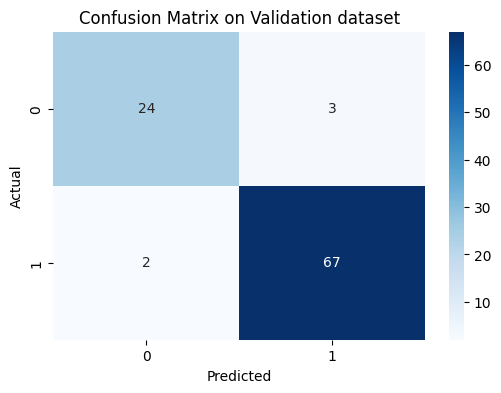

Classifiation Report on Validation dataset
              precision    recall  f1-score   support

      cancer     0.9231    0.8889    0.9057        27
      normal     0.9571    0.9710    0.9640        69

    accuracy                         0.9479        96
   macro avg     0.9401    0.9300    0.9348        96
weighted avg     0.9476    0.9479    0.9476        96



In [11]:
print("EfficientNetB0 model \ntrained in 719 images(188 cancer + 531 normal)")
report(effnet_model_1)

EfficientNetB0 model 
trained in 730 images(199 cancer + 531 normal)
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 386ms/step - accuracy: 0.9765 - auc: 0.9962 - loss: 0.0822
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 382ms/step - accuracy: 0.9375 - auc: 0.9536 - loss: 0.1939
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 6s/step - accuracy: 0.9551 - auc: 0.9217 - loss: 0.2577
[train] acc: 0.9740 - auc: 0.9961 - loss: 0.0874
[val]   acc: 0.9375 - auc: 0.9511 - loss: 0.2037
[test]  acc: 0.9483 - auc: 0.9091 - loss: 0.2769

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step
cancer: 0, normal: 1


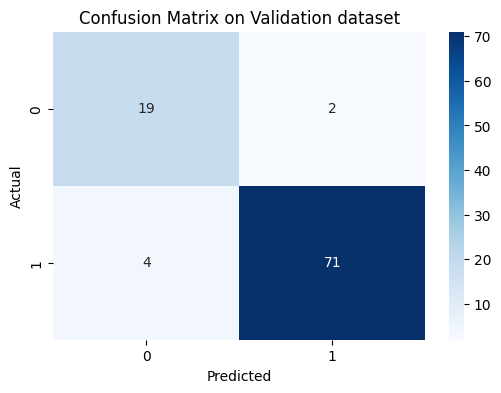

Classifiation Report on Validation dataset
              precision    recall  f1-score   support

      cancer     0.8261    0.9048    0.8636        21
      normal     0.9726    0.9467    0.9595        75

    accuracy                         0.9375        96
   macro avg     0.8993    0.9257    0.9115        96
weighted avg     0.9406    0.9375    0.9385        96



In [11]:
print("EfficientNetB0 model \ntrained in 730 images(199 cancer + 531 normal)")
report(effnet_model_2)

EfficientNetB0 model 
trained in 2413 images(199 cancer + 2214 normal)
60/60 ━━━━━━━━━━━━━━━━━━━━ 631s 10s/step - accuracy: 0.9846 - auc: 0.9943 - loss: 0.0575
8/8 ━━━━━━━━━━━━━━━━━━━━ 113s 7s/step - accuracy: 0.9632 - auc: 0.9550 - loss: 0.1149
8/8 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - accuracy: 0.9178 - auc: 0.8890 - loss: 0.2045
[train] acc: 0.9849 - auc: 0.9951 - loss: 0.0545
[val]   acc: 0.9570 - auc: 0.9605 - loss: 0.1302
[test]  acc: 0.9283 - auc: 0.9138 - loss: 0.1787

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step
cancer: 0, normal: 1


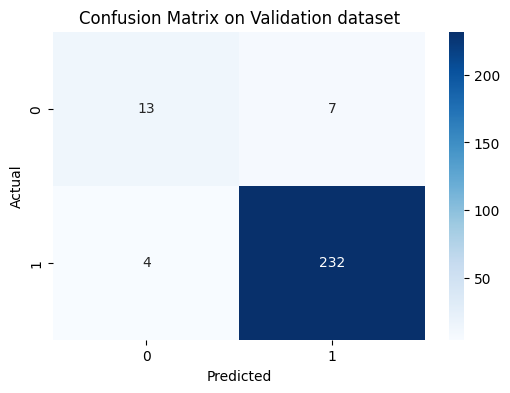

Classifiation Report on Validation dataset
              precision    recall  f1-score   support

      cancer     0.7647    0.6500    0.7027        20
      normal     0.9707    0.9831    0.9768       236

    accuracy                         0.9570       256
   macro avg     0.8677    0.8165    0.8398       256
weighted avg     0.9546    0.9570    0.9554       256



In [18]:
print("EfficientNetB0 model \ntrained in 2413 images(199 cancer + 2214 normal)")
report(effnet_model_3)